In [100]:
'''

#Enable GPU for this Exercise.

'''

'\n\n#Enable GPU for this Exercise.\n\n'

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from skorch import NeuralNet, dataset


# This package is helpful to apply noise to our images
import skimage

torch.manual_seed(0)

In [102]:
#If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


'''
Import Mnist
'''
mnist = datasets.MNIST(root = './data', 
                        train = True, 
                        transform = transforms.ToTensor(),  
                        download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms.ToTensor())


X_train = mnist.data
X_test = test_dataset.data

'''
Normalize each input from [0.0,1.0] range
'''

X_train = X_train / 255.0
X_test = X_test / 255.0

'''
Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# X_train, X_valid = X_train[:30000], X_train[30000:]



In [103]:
# create your training sets (X_train_GN) and (X_train_SP)

seed = 42

X_train_GN = skimage.util.random_noise(X_train, mode='gaussian', seed=seed, clip=True).astype('float32')
X_train_SP = skimage.util.random_noise(X_train, mode='s&p', seed=seed, clip=True)

In [104]:
def plot_one_row(X, rows, cols, index, **kwargs):
    """Plot the first 5 images and their labels in a row."""
    for i, img in enumerate(X[:cols].reshape(cols, 28, 28)):
        plt.subplot(rows, cols, 1 + i + index, **kwargs)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])


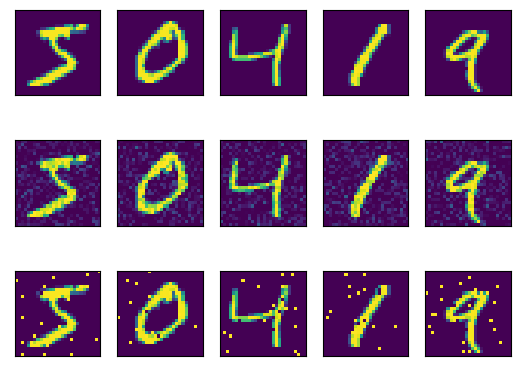

In [105]:
# Plot five images from the original dataset, the noisy Gaussian dataset, and the noisy salt-and-pepper dataset

plot_one_row(X_train, 3, 5, 0)
plot_one_row(X_train_GN, 3, 5, 5)
plot_one_row(X_train_SP, 3, 5, 10)

In [106]:
'''
Create the architecture 

'''

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(  
            # Convolutions
            nn.Conv2d(1, 8, kernel_size=5, padding=2), # batch x 8 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # batch x 8 x 14 x 14
            nn.Conv2d(8, 16, kernel_size=5, padding=2), # batch x 16 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # batch x 16 x 7 x 7
            # Fully connected layers
            nn.Flatten(start_dim=1),
            nn.Linear(16 * 7 * 7, 64),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            # Fully connected layers
            nn.Linear(32, 64),
            nn.Linear(64, 16 * 7 * 7),
            nn.Unflatten(dim=1, unflattened_size=(16, 7, 7)),
                        # Convolutions
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1), # batch x 8 x 14 x 14
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1), # batch x 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [107]:
# define the network to be train with the salt and pepper corrupted images
# train the network

AutoNN_SP = NeuralNet(
    # Module
    module=Autoencoder,
    max_epochs=10,
    # Optimizer
    optimizer=torch.optim.Adam,
    lr=0.005,
    optimizer__weight_decay=0,
    # Loss function
    criterion=torch.nn.MSELoss,
    # Other
    device=device,
    train_split=dataset.ValidSplit(0.5),
)

AutoNN_SP.fit(X_train_SP, X_train)

print("\nTraining with salt and pepper noise")
print(f"Training loss:   {AutoNN_SP.history[:, 'train_loss'][-1]:.6f}")
print(f"Validation loss: {AutoNN_SP.history[:, 'valid_loss'][-1]:.6f}")


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1146        0.1124  2.1276
      2        0.1122        0.1124  2.1299

Training with salt and pepper noise
Training loss:   0.112151
Validation loss: 0.112352


In [ ]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 
AutoNN_GN = NeuralNet(
    # Module
    module=Autoencoder,
    max_epochs=10,
    # Optimizer
    optimizer=torch.optim.Adam,
    lr=0.005,
    optimizer__weight_decay=0,
    # Loss function
    criterion=torch.nn.MSELoss,
    # Other
    device=device,
    train_split=dataset.ValidSplit(0.5),
)

AutoNN_GN.fit(X_train_GN, X_train)

print("\nTraining with gaussian noise")
print(f"Training loss:   {AutoNN_GN.history[:, 'train_loss'][-1]:.6f}")
print(f"Validation loss: {AutoNN_GN.history[:, 'valid_loss'][-1]:.6f}")


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0427        0.0227  2.1200
      2        0.0189        0.0156  2.1464
      3        0.0140        0.0129  2.1507
      4        0.0120        0.0116  2.1531
      5        0.0111        0.0111  2.1263
      6        0.0106        0.0107  2.1341
      7        0.0101        0.0101  2.1662
      8        0.0098        0.0098  2.1352
      9        0.0094        0.0096  2.1086
     10        0.0092        0.0094  2.2024

Training with gaussian noise
Training loss:   0.009170
Validation loss: 0.009416


In [ ]:
def get_test_error(model, y_pred, y_true):
    y_pred = torch.tensor(y_pred).to(device)
    return model.get_loss(y_pred, y_true).item()

Test error: 0.010325


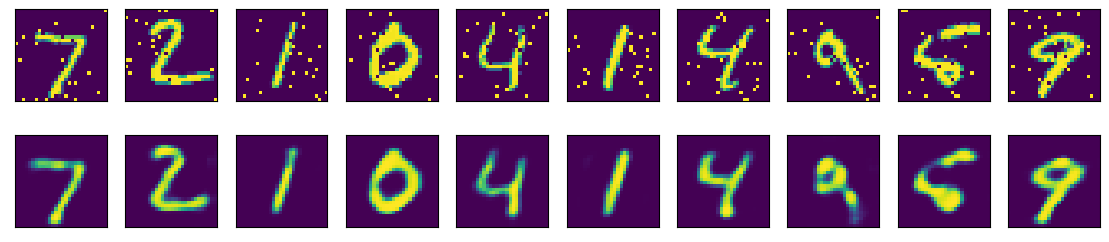

In [ ]:
# corrupt test images with Salt and pepper, pass them through AutoNN_SP 
# plot the results 

X_test_SP = skimage.util.random_noise(X_test[:10], mode='s&p', seed=seed, clip=True)
predictions = AutoNN_SP.predict(X_test_SP)

plt.figure(figsize=(14, 3))
plot_one_row(X_test_SP, 2, 10, 0)
plot_one_row(predictions,2, 10, 10)

print(f"Test error: {get_test_error(AutoNN_SP, predictions, X_test[:10]):.6f}")



Test error: 0.008267


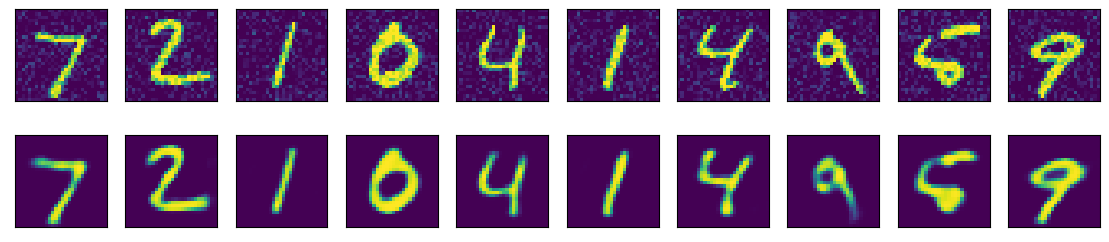

In [ ]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 


X_test_GN = skimage.util.random_noise(X_test[:10], mode='gaussian', seed=seed, clip=True).astype('float32')
predictions = AutoNN_GN.predict(X_test_GN)

plt.figure(figsize=(14, 3))
plot_one_row(X_test_GN, 2, 10, 0)
plot_one_row(predictions,2, 10, 10)

print(f"Test error: {get_test_error(AutoNN_GN, predictions, X_test[:10]):.6f}")